In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy
import datetime as dt

In [40]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df = train_df. interpolate()
test_df = test_df. interpolate()

test_id = test_df["ID"]

train_df.drop('ID', inplace=True, axis=1)
test_df.drop('ID', inplace=True, axis=1)

print(train_df.isna().sum().sum())
print(test_df.isna().sum().sum())

0
0


In [26]:
train_df['Gender'] = train_df['Gender'].map({'Male' : 0, 'Female' : 1})
train_df['Customer Type'] = train_df['Customer Type'].map({'Returning' : 0, 'First-time' : 1})
train_df['Type of Travel'] = train_df['Type of Travel'].map({'Personal' : 0, 'Business' : 1})
train_df['Class'] = train_df['Class'].map({'Business' : 2, 'Economy Plus' : 1, 'Economy' : 0})
train_df['Satisfaction'] = train_df['Satisfaction'].map({'Neutral or Dissatisfied' : 0, 'Satisfied' : 1})

test_df['Gender'] = test_df['Gender'].map({'Male' : 0, 'Female' : 1})
test_df['Customer Type'] = test_df['Customer Type'].map({'Returning' : 0, 'First-time' : 1})
test_df['Type of Travel'] = test_df['Type of Travel'].map({'Personal' : 0, 'Business' : 1})
test_df['Class'] = test_df['Class'].map({'Business' : 2, 'Economy Plus' : 1, 'Economy' : 0})

In [27]:
ReLU = nn.ReLU()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(22, 64)
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x):
        x = ReLU(self.fc1(x))
        x = ReLU(self.fc2(x))
        x = ReLU(self.fc3(x))
        x = ReLU(self.fc4(x))

        x = torch.sigmoid(self.fc5(x))
        return x.view(-1)

In [34]:
class MyDataset(Dataset):

    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.y[index])

In [29]:
class Trainer():
    def __init__(self,  dataset, net, loss_f, learning_rate=1e-3,
                epoch_amount=10, batch_size=12,
                max_batches_per_epoch=None,
                device='cpu', early_stopping=10,
                optim=torch.optim.Adam,
                scheduler=None, permutate=True):
        
        self.accuracy_metric = Accuracy(task='binary').to(device) 
        self.loss_f = loss_f
        self.learning_rate = learning_rate
        self.epoch_amount = epoch_amount
        self.batch_size = batch_size
        self.max_batches_per_epoch = max_batches_per_epoch
        self.device = device
        self.early_stopping = early_stopping
        self.optim = optim
        self.scheduler = scheduler
        self.permutate = permutate
        self.dataset = dataset
        self.start_model = net
        self.best_model = net

        self.train_loss = []
        self.val_loss = []

    def predict(self, X):
        return self.best_model(X)

    def fit(self, X_train, X_test, y_train, y_test):

        Net = self.start_model


        Net.to(self.device)

        optimizer = self.optim(Net.parameters(), lr=self.learning_rate)
        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer, step_size=4, gamma=0.5)

        train = self.dataset(X_train, y_train)
        val = self.dataset(X_test, y_test)

        train = DataLoader(train, batch_size=self.batch_size, shuffle=self.permutate)
        val = DataLoader(val, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf')
                                   
        best_ep = 0                
        for epoch in range(self.epoch_amount):
            start = dt.datetime.now()
            print(f'Эпоха: {epoch}', end=' ')
            Net.train()
            mean_loss = 0
            batch_n = 0

            for batch_X, target in train:
                if self.max_batches_per_epoch is not None:
                    if batch_n >= self.max_batches_per_epoch:
                        break
                optimizer.zero_grad()

                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)
                loss.backward()
                optimizer.step()

                mean_loss += float(loss)
                batch_n += 1

            mean_loss /= batch_n
            self.train_loss.append(mean_loss)
            print(f'Loss_train: {mean_loss}, {dt.datetime.now() - start} сек')

            Net.eval()
            mean_loss = 0
            batch_n = 0

            
            with torch.no_grad():
                for batch_X, target in val:
                    if self.max_batches_per_epoch is not None:
                        if batch_n >= self.max_batches_per_epoch:
                            break
                    batch_X = batch_X.to(self.device)
                    target = target.to(self.device)

                    predicted_values = Net(batch_X)
                    loss = self.loss_f(predicted_values, target)
                    self.accuracy_metric.update(predicted_values, target)

                    mean_loss += float(loss)
                    batch_n += 1
                
                mean_loss /= batch_n
                accuracy = self.accuracy_metric.compute()
                self.val_loss.append(mean_loss)
                print(f'Loss_val: {mean_loss}')
                print(f'Accuracy: {accuracy}')

            if mean_loss < best_val_loss:
                self.best_model = Net
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break
            if self.scheduler is not None:
                scheduler.step()
            print()

In [30]:
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=22, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
)


In [31]:
X, Y = train_df.drop("Satisfaction", axis=1), train_df['Satisfaction']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)

In [35]:
params = {
    'dataset': MyDataset,
    'net': net,
    'epoch_amount': 100,
    'learning_rate': 1e-2,
    'early_stopping': 10,
    "batch_size": 64,
    'loss_f': nn.BCELoss(),
    "scheduler": StepLR,
}

clf = Trainer(**params)
clf.fit(X_train.to_numpy(), X_val.to_numpy(), y_train.to_numpy(), y_val.to_numpy())

Эпоха: 0 Loss_train: 0.25014944773374137, 0:00:02.526027 сек
Loss_val: 0.23606500774621964
Accuracy: 0.898140549659729

Эпоха: 1 Loss_train: 0.2434331301813516, 0:00:02.536591 сек
Loss_val: 0.24848195941264467
Accuracy: 0.898817241191864

Эпоха: 2 Loss_train: 0.23690471303213811, 0:00:02.642179 сек
Loss_val: 0.25575672050839976
Accuracy: 0.8979443907737732

Эпоха: 3 Loss_train: 0.2598100234793809, 0:00:02.667584 сек
Loss_val: 0.22834932750889234
Accuracy: 0.900170624256134

Эпоха: 4 Loss_train: 0.20318109640257603, 0:00:02.635423 сек
Loss_val: 0.19086378168566784
Accuracy: 0.9035542011260986

Эпоха: 5 Loss_train: 0.20431072462213454, 0:00:02.714887 сек
Loss_val: 0.17652961141184756
Accuracy: 0.9073496460914612

Эпоха: 6 Loss_train: 0.20104479170838058, 0:00:02.645626 сек
Loss_val: 0.20650643457595566
Accuracy: 0.9078582525253296

Эпоха: 7 Loss_train: 0.20272753347738218, 0:00:02.670802 сек
Loss_val: 0.19042024055593892
Accuracy: 0.9090487957000732

Эпоха: 8 Loss_train: 0.18470081912663

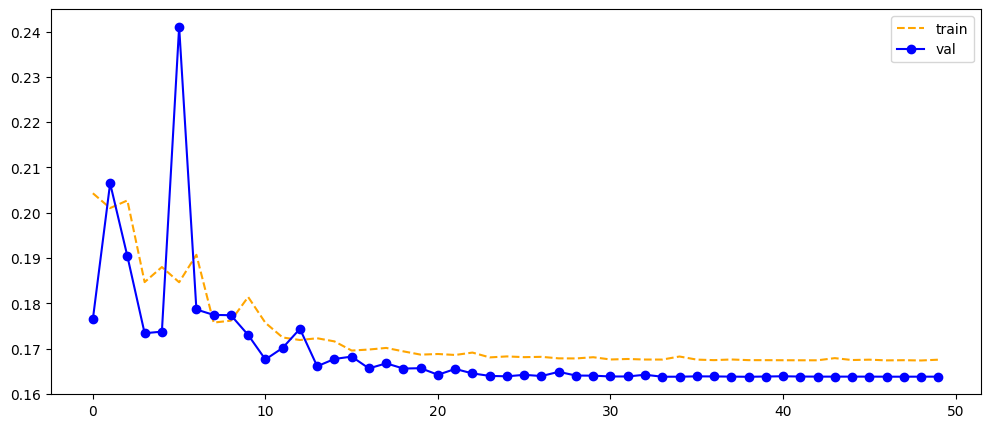

In [36]:
def plot_loss(Loss_train, Loss_val):
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(Loss_train)), Loss_train, color='orange', label='train', linestyle='--')
    plt.plot(range(len(Loss_val)), Loss_val, color='blue', marker='o', label='val')
    plt.legend()
    plt.show()

plot_loss(clf.train_loss[5:], clf.val_loss[5:])

In [ ]:
X_test = torch.tensor(test_df.to_numpy(), dtype=torch.float)
ans = clf.predict(X_test).detach().numpy()

In [38]:
ans = ans > 0.5

In [41]:
from pandas import DataFrame


df = DataFrame({
    "ID" : test_id,
    "Satisfaction": np.int8(ans)
})

In [42]:
df.to_csv("ans.csv", index=False)